In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, average_precision_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score
from tqdm.auto import tqdm

from graph import _get_genes, _get_phenotypes, _get_positive_negative_edges, _load_gen_df, _load_phn_df, _merge_dfs

In [2]:
df = pd.read_csv('results.csv')
df

,Gen,Phn,p
0,SLC9A1,D1071,0.983144
1,MAGI3,D1071,0.874537
2,S100A14,D1071,0.728153
3,C1orf35,D1071,0.831546
4,SUPT7L,D1071,0.994575
...,...,...,...
703003,DDX11,D1222,0.002606
703004,ITPK1,D1222,0.002593
703005,MORF4,D1222,0.001918
703006,NINJ1,D1222,0.002593


In [3]:
df_gen = _load_gen_df()
df_phn = _load_phn_df()

genes = _get_genes(df_gen, df_phn)
phenotypes = _get_phenotypes(df_phn)

positive_edges, _ = _get_positive_negative_edges(_merge_dfs(df_gen, df_phn), genes, phenotypes)
positive_edges = pd.DataFrame({'Gen': positive_edges['Nod_B'], 'Phn': positive_edges['Nod_A'], 'GT': 1})
positive_edges

,Gen,Phn,GT
0,CDK11B,D1071,1
1,CDK11A,D1071,1
2,NADK,D1071,1
3,GNB1,D1071,1
4,PRDM16,D1071,1
...,...,...,...
684045,NCKAP1,D1095,1
693846,PPP1R13B,D1222,1
702637,ATP5MJ,D1222,1
702638,TDRD9,D1222,1


In [4]:
df = pd.merge(df, positive_edges, on=['Gen', 'Phn'], how='left').fillna(0)
df['GT'] = df['GT'].astype(int)
df

,Gen,Phn,p,GT
0,SLC9A1,D1071,0.983144,1
1,MAGI3,D1071,0.874537,1
2,S100A14,D1071,0.728153,1
3,C1orf35,D1071,0.831546,1
4,SUPT7L,D1071,0.994575,1
...,...,...,...,...
703003,DDX11,D1222,0.002606,0
703004,ITPK1,D1222,0.002593,0
703005,MORF4,D1222,0.001918,0
703006,NINJ1,D1222,0.002593,0


Plot probability distribution returned by the model:

<AxesSubplot:>

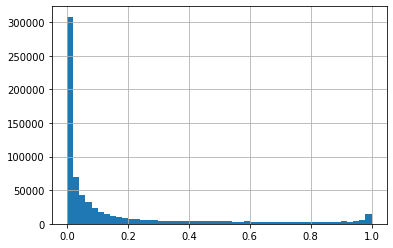

In [5]:
df['p'].hist(bins=50)

Compute performance metrics across all cross-validation folds:

In [6]:
y_test = df['GT'].values
y_prob = df['p'].values
y_pred = (y_prob > 0.5).astype(int)

{
    'Acc': np.round(accuracy_score(y_test, y_pred), 4),
    'BAC': np.round(balanced_accuracy_score(y_test, y_pred), 4),
    'Precision': np.round(precision_score(y_test, y_pred), 4),
    'Recall': np.round(recall_score(y_test, y_pred), 4),
    'PR-AUC': np.round(average_precision_score(y_test, y_prob), 4),
    'AUC': np.round(roc_auc_score(y_test, y_prob), 4),
}

{'Acc': 0.879,
 'BAC': 0.8895,
 'Precision': 0.0971,
 'Recall': 0.9003,
 'PR-AUC': 0.4331,
 'AUC': 0.9512}

Plot confusion matrix, with probability threshold for link prediction = 0.5:

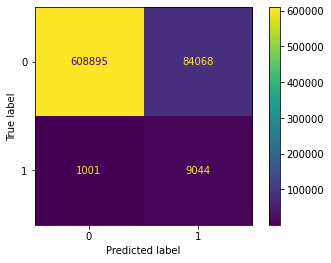

In [7]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Plot confusion matrix, with probability threshold for link prediction = 0.9:

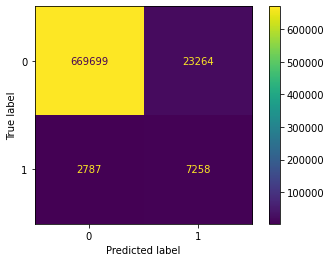

In [8]:
cm = confusion_matrix(y_test, (y_prob > 0.9).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Split dataframe into known (`df_o`) and unknown (`df_n`) links:

In [9]:
df_o = df[df['GT'] == 1].copy()
df_o

,Gen,Phn,p,GT
0,SLC9A1,D1071,0.983144,1
1,MAGI3,D1071,0.874537,1
2,S100A14,D1071,0.728153,1
3,C1orf35,D1071,0.831546,1
4,SUPT7L,D1071,0.994575,1
...,...,...,...,...
564411,PPFIA4,D1094,0.021077,1
564412,NCBP1,D1094,0.011201,1
564413,HAUS4P1,D1094,0.946368,1
564414,TSTD2,D1094,0.946368,1


For unknown links also compute the hits at both thresholds (0.5 and 0.9):

In [10]:
df_n = df[df['GT'] == 0].copy()
df_n['h.5'] = (df_n['p'] > 0.5).astype(int)
df_n['h.9'] = (df_n['p'] > 0.9).astype(int)
df_n

,Gen,Phn,p,GT,h.5,h.9
2009,HIPK1,D1071,0.868193,0,1,0
2010,BCAS2,D1071,0.992022,0,1,1
2011,SSR1,D1071,0.984533,0,1,1
2012,HLA-A,D1071,0.999580,0,1,1
2013,TRIM26,D1071,0.998707,0,1,1
...,...,...,...,...,...,...
703003,DDX11,D1222,0.002606,0,0,0
703004,ITPK1,D1222,0.002593,0,0,0
703005,MORF4,D1222,0.001918,0,0,0
703006,NINJ1,D1222,0.002593,0,0,0


Count the number of known links per phenotype:

In [11]:
df_o['Phn'].value_counts()

D1071    1105
D1251    1022
D1249    1003
D1075     752
D1536     494
         ... 
D1074       3
D1304       3
D1280       1
D1154       1
D1095       1
Name: Phn, Length: 72, dtype: int64

Count the number of predicted unknown links per phenotype:

In [12]:
df_n.groupby('Phn')[['h.5', 'h.9']].agg('sum').reset_index()

,Phn,h.5,h.9
0,C1007,338,15
1,C1010,604,205
2,C1052,418,94
3,C1067,445,203
4,C1068,444,184
...,...,...,...
67,L2003,207,22
68,L2004,329,113
69,L2005,339,113
70,L2006,319,116


In [13]:
counts = df_n.groupby('Phn')[['h.5', 'h.9']].agg('sum')
counts = counts.merge(df_o['Phn'].value_counts().to_frame(), left_index=True, right_index=True)
counts = counts.rename(columns={'Phn': '# of known edges'})
counts = counts[['# of known edges', 'h.5', 'h.9']]
counts = counts.sort_values('# of known edges', ascending=False)

print(counts.to_string())

        # of known edges   h.5   h.9
D1071               1105  8520  3570
D1251               1022  5934  1501
D1249               1003  5177  1389
D1075                752  1942   779
D1536                494  6317  1451
D1250                482  1454   628
D1416                396  1441   559
D1245                372  2351   852
D1153                369  1385   526
ModDRm               334  7407  2061
HumAge               307  6481  1223
D1524                295  1359   497
HumCel               279  6892  1558
D1155                263  1267   467
D1284                259  1248   416
D1526                221  5082   917
D1269                157  1267   418
C1010                153   604   205
C1068                115   444   184
D1523                111  1046   234
C1069                110   415   176
D1085                 87   367   147
D1112                 79   384   158
C1067                 68   445   203
D1182                 66   605   265
D1183                 63   586   252
D

Create dataframe containing probability matrix of predicted link probability between genes and phenotypes:

In [14]:
rows = []

for gene in tqdm(genes):
    row = []
    
    ds = df[df['Gen'] == gene]
    
    for phenotype in phenotypes:
        dx = ds[ds['Phn'] == phenotype]
        
        assert len(dx) == 1
        
        if dx['GT'].iloc[0] == 1:
            row.append(np.nan)
        else:
            row.append(dx['p'].iloc[0])
    
    rows.append(row)

dm = pd.DataFrame(rows, columns=phenotypes)
dm

  0%|          | 0/9764 [00:00<?, ?it/s]

,D1071,HumCel,D1536,D1251,D1249,D1526,ModDRm,D1091,D1092,D1082,...,D1351,D1595,D1154,D1218,D1304,D1094,D1280,D1518,D1095,D1222
0,NaN,0.697279,0.491071,0.857771,0.449491,0.421432,0.940757,0.011642,0.036145,0.031787,...,0.035537,0.000751,0.057457,0.013535,0.000000,0.087775,0.000000,0.155300,0.036024,0.000413
1,NaN,0.882499,0.674520,0.669357,0.967413,0.638859,0.884481,0.067023,0.004667,0.006852,...,0.000004,0.014790,0.073973,0.002993,0.016670,0.063758,0.000000,0.007111,0.000000,0.000000
2,NaN,NaN,0.293267,0.325787,0.290905,0.270313,0.604203,0.002216,0.000098,0.000000,...,0.000001,0.000000,0.000690,0.008878,0.000042,0.052784,0.000000,0.093792,0.000000,0.060533
3,NaN,0.996982,0.999584,0.998731,0.993539,0.984921,0.999753,0.298116,0.402694,0.084520,...,0.000240,0.418824,0.009734,0.004118,0.201912,0.533420,0.000000,0.425361,0.034580,0.000000
4,NaN,0.509732,0.332478,0.882843,0.384218,0.285343,0.571717,0.028077,0.008057,0.009448,...,0.000000,0.038436,0.000678,0.009254,0.000000,0.004291,0.000000,0.004557,0.000765,0.000242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9759,0.967366,NaN,0.425078,0.411017,0.296227,0.691693,0.904599,0.003509,0.035584,0.020175,...,0.000000,0.000000,0.002417,0.016109,0.066946,0.058469,0.063528,0.141783,0.000000,0.091899
9760,0.777208,NaN,0.369601,0.682827,0.407198,0.443658,0.882954,0.005623,0.015846,0.020175,...,0.000000,0.004648,0.000000,0.057406,0.000000,0.124660,0.001711,0.141783,0.046731,0.000682
9761,0.781053,NaN,0.448070,0.343833,0.296227,0.607424,0.882954,0.003509,0.001678,0.020175,...,0.011962,0.004648,0.058557,0.019101,0.103236,0.116014,0.000000,0.110369,0.049338,0.001918
9762,0.957599,NaN,0.523410,0.411017,0.381746,0.443658,0.882954,0.003509,0.058805,0.000000,...,0.000000,0.000000,0.000000,0.040222,0.000000,0.058469,0.063528,0.052242,0.076401,0.000000


Add information about the sum of predicted probabilities for each gene:

In [15]:
dm.index = genes
dm['Total'] = dm[phenotypes].sum(axis=1)
dm = dm.sort_values('Total', ascending=False)
dm

,D1071,HumCel,D1536,D1251,D1249,D1526,ModDRm,D1091,D1092,D1082,...,D1595,D1154,D1218,D1304,D1094,D1280,D1518,D1095,D1222,Total
KRAS,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,0.468562,0.907545,0.766440,...,0.000000,0.007306,0.040230,0.898968,0.990402,0.023601,0.638328,0.000000,0.000000,45.076546
CTSH,0.941291,0.410305,0.934390,0.710657,0.689935,0.472818,0.167186,NaN,0.999974,0.986942,...,0.999986,0.016503,0.007995,0.000000,0.150382,0.000000,0.013086,0.966441,0.000000,40.556071
TP53,1.000000,NaN,1.000000,0.999999,0.999999,0.999956,1.000000,0.246774,0.288298,0.207309,...,0.119327,0.527316,0.238734,0.000000,0.506676,0.000000,0.767903,0.733127,0.003526,40.433531
LPA,NaN,0.374338,NaN,0.999449,0.999014,0.905032,0.596567,NaN,NaN,NaN,...,0.518714,0.882198,0.009912,0.123852,0.165925,0.000000,0.220556,0.025120,0.123830,38.868848
LINC01768,NaN,0.263452,NaN,0.954771,0.997142,0.767153,0.189350,NaN,NaN,NaN,...,0.710659,0.928170,0.265148,0.000000,0.019783,0.096087,0.029782,0.000054,0.000000,38.775740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCNG1,0.362724,0.439184,0.132409,0.267633,0.249828,0.214931,0.482770,0.002384,0.009650,0.000000,...,0.000000,0.000000,0.005002,0.000352,0.004747,0.000000,0.034281,0.016913,0.000000,3.531663
TUBB2A,0.460752,0.388222,0.138159,0.112159,0.325748,0.258130,0.454567,0.002364,0.000000,0.000000,...,0.003520,0.000000,0.002189,0.000300,0.004137,0.000000,0.013119,0.000532,0.000000,3.493053
E4F1,0.470875,0.425568,0.290165,0.382616,0.077329,0.213390,0.468356,0.001471,0.009615,0.007962,...,0.000000,0.000432,0.007197,0.000000,0.002126,0.000000,0.020642,0.018577,0.000000,3.361788
KDM4A,0.647473,NaN,0.285656,0.118482,0.101057,0.251875,0.525823,0.000157,0.018713,0.000000,...,0.000000,0.000599,0.009676,0.000289,0.036353,0.000000,0.004885,0.000000,0.000533,3.347281


Show the sum of predicted probabilities for each phenotype:

In [16]:
print(dm[phenotypes].sum(axis=0).to_string())

D1071     7291.457936
HumCel    5954.379645
D1536     5800.762330
D1251     5404.971573
D1249     5135.349127
D1526     5277.445018
ModDRm    6398.111150
D1091      746.313105
D1092      694.687736
D1082      618.172571
L2001      874.388956
L2005      734.775594
D1112      858.985226
D1111      673.227763
D1502      443.486304
D1085      880.243452
D1245     3609.582246
D1075     3018.016458
D1183      821.048025
D1182      843.175715
D1156      639.487669
D1248      512.854475
C1007     1466.364259
D1525     1323.504128
HumAge    5741.103021
D1077      770.920405
D1321     1225.781483
C1010     1427.057043
C1068      966.084257
C1069      898.557627
D1250     1712.089711
D1416     1613.765825
D1153     1613.851493
D1524     1551.060486
D1269     1498.366189
D1284     1450.521653
D1523     1286.655447
D1537      996.111662
D1320      968.908038
D1155     1514.135792
L2003      507.796712
D1159      864.147028
D1268      527.280707
C1080      427.649185
D1073      782.386229
D1076     

Calculate the number of known links for each gene, and compare that with the sum of predicted probabilities of novel ones:

In [17]:
dm['Known'] = dm.isna().sum(axis=1)

In [18]:
print(dm[['Total', 'Known']].iloc[:100].to_string())

                  Total  Known
KRAS          45.076546      1
CTSH          40.556071      6
TP53          40.433531      2
LPA           38.868848      8
LINC01768     38.775740      7
MIR6088       38.657545     12
ERCC1         38.260888     13
MAP3K4-AS1    38.215281     11
EGFR          37.469363      1
LINC02166     37.221924      6
DBNDD1        37.003720      5
VPS9D1        36.973566      6
CHMP1A        36.948518      5
PUDPP3        36.944856      4
MAP3K4        36.867056     11
CHRNB4        36.762952      4
AGPAT4        36.451515      7
PLG           36.139647      8
PRKN          36.014601      7
RNU6-415P     35.709832      5
TMEM116       35.661753     10
CDKN2B-AS1    35.631821     15
RPS2P41       35.536879     11
TCF25         35.452110      7
ADAM1A        35.196844     10
SPPL2A        35.187681      1
RPS16P9       35.164334      5
NAA25         35.054831     10
HNRNPA1P52    35.042845      3
MC1R          34.725027      6
SLC22A3       34.668367      5
MEIOSIN 

Plot the histogram of sums of predicted probabilities for all genes:

<AxesSubplot:>

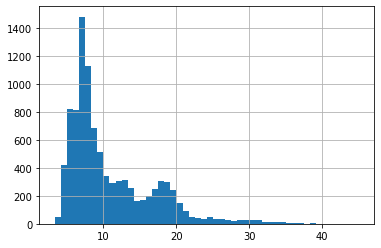

In [19]:
dm['Total'].hist(bins=50)